In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


import sys

sys.path.append('../')

from eda import utils

In [3]:
tracks = utils.load('../data/fma_metadata/tracks.csv')
feats = utils.load('../data/fma_metadata/features.csv')

In [4]:
small = tracks['set', 'subset'] <= 'small'

X = feats.loc[small]
y = tracks['track', 'genre_top'].loc[small]

#uncomment for 5-class or 2-class
#y = y.loc[(y == 'Rock') | (y == 'Electronic') | (y == 'Instrumental') | (y == 'Hip-Hop') | (y == 'Pop')]
#y = y.loc[(y == 'Rock') | (y == 'Electronic')]
print(y.value_counts())

X = X.loc[X.index.isin(y.index)]

#uncomment for top 5 features
mfcc = X.iloc[:, X.columns.get_loc('mfcc')]
rmse = X.iloc[:, X.columns.get_loc('rmse')]
spectral_bandwidth = X.iloc[:, X.columns.get_loc('spectral_bandwidth')]
spectral_centroid = X.iloc[:, X.columns.get_loc('spectral_centroid')]
spectral_contrast = X.iloc[:, X.columns.get_loc('spectral_contrast')]

X = pd.concat([mfcc, rmse, spectral_bandwidth, spectral_centroid, spectral_contrast], axis=1)
print(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

Electronic             1000
Experimental           1000
Folk                   1000
Hip-Hop                1000
Instrumental           1000
International          1000
Pop                    1000
Rock                   1000
Blues                     0
Classical                 0
Country                   0
Easy Listening            0
Jazz                      0
Old-Time / Historic       0
Soul-RnB                  0
Spoken                    0
Name: (track, genre_top), dtype: int64
feature         mfcc                                                    \
statistics  kurtosis                                                     
number            01        02        03        04        05        06   
track_id                                                                 
2           3.856789  1.541901  0.000816  0.330728  0.118731 -0.342687   
5           2.624517  2.415293  0.440233 -0.782131 -0.771069 -0.724216   
10          5.076893  1.161854  2.095651  1.372743 -0.203574 -0.34535

In [63]:
large = pd.read_csv('large.csv')
y = large.iloc[:, 518]
X = large.drop(large.columns[518], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

In [5]:
sc = StandardScaler()
X_train2 = X_train.copy()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'relu', learning_rate_init = 0.1, batch_size = 300, hidden_layer_sizes = (200,100), max_iter = 100)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

In [5]:
from sklearn.feature_selection import SequentialFeatureSelector

In [8]:
sfs = SequentialFeatureSelector(mlp, n_features_to_select=100, n_jobs=-1)

In [9]:
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=MLPClassifier(batch_size=300,
                                                  hidden_layer_sizes=(200, 100),
                                                  learning_rate_init=0.1,
                                                  max_iter=100, random_state=42,
                                                  solver='sgd'),
                          n_features_to_select=100, n_jobs=-1)

In [10]:
sfs.get_support()

array([False, False,  True, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,

In [55]:
print(X_train.shape)
X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)
print(X_train_sfs.shape)
print(X_test_sfs.shape)

(4000, 518)
(4000, 100)
(1000, 100)


In [56]:
mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'relu', learning_rate_init = 0.1, batch_size = 300, hidden_layer_sizes = (200,100), max_iter = 100)
mlp.fit(X_train_sfs, y_train)
y_pred = mlp.predict(X_test_sfs)

In [6]:
print(mlp.classes_)

['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Instrumental'
 'International' 'Pop' 'Rock']


Accuracy: 0.60875

Classification Report:
               precision    recall  f1-score   support

   Electronic       0.56      0.54      0.55        98
 Experimental       0.45      0.54      0.49        80
         Folk       0.65      0.67      0.66       105
      Hip-Hop       0.67      0.66      0.66        93
 Instrumental       0.65      0.61      0.63       117
International       0.77      0.70      0.73       119
          Pop       0.43      0.47      0.45        83
         Rock       0.65      0.64      0.64       105

     accuracy                           0.61       800
    macro avg       0.60      0.60      0.60       800
 weighted avg       0.62      0.61      0.61       800



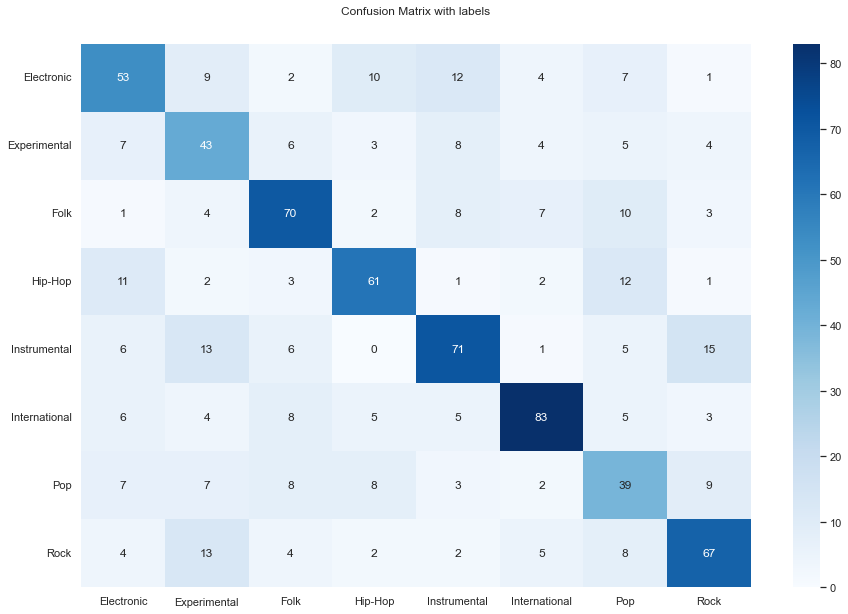

In [7]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
cf_mat = confusion_matrix(y_test, y_pred)
sns.set(rc = {'figure.figsize':(15,10)})

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', fmt='g')
ax.set_xticklabels(mlp.classes_)
kwargs = {'rotation': 'horizontal'}
ax.set_yticklabels(mlp.classes_, **kwargs)

ax.set_title('Confusion Matrix with labels\n\n')

## Display the visualization of the Confusion Matrix.
plt.show()

In [8]:
from sklearn.model_selection import GridSearchCV

learning_rate_init = [0.1, 0.2, 0.3]
max_iter = [100, 300]
hidden_layer_sizes = [(200,100), (200,50), (100,50)]
solver = ['sgd']
random_state = [42]
activation = ['logistic', 'relu']
batch_size = [100, 300]


# Make a dictionary of the grid search parameters
param_grid = dict(learning_rate_init=learning_rate_init, max_iter=max_iter, hidden_layer_sizes=hidden_layer_sizes, solver=solver, random_state=random_state, activation=activation, batch_size=batch_size)

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator=mlp, param_grid=param_grid)

grid.fit(X_train, y_train)
print(grid.best_params_)

c:\Users\micha\anaconda3\envs\env1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\micha\anaconda3\envs\env1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\micha\anaconda3\envs\env1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\micha\anaconda3\envs\env1\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\micha\anaconda3\envs\en

{'activation': 'relu', 'batch_size': 300, 'hidden_layer_sizes': (200, 100), 'learning_rate_init': 0.1, 'max_iter': 100, 'random_state': 42, 'solver': 'sgd'}


Accuracy: 0.60875

Classification Report:
               precision    recall  f1-score   support

   Electronic       0.56      0.54      0.55        98
 Experimental       0.45      0.54      0.49        80
         Folk       0.65      0.67      0.66       105
      Hip-Hop       0.67      0.66      0.66        93
 Instrumental       0.65      0.61      0.63       117
International       0.77      0.70      0.73       119
          Pop       0.43      0.47      0.45        83
         Rock       0.65      0.64      0.64       105

     accuracy                           0.61       800
    macro avg       0.60      0.60      0.60       800
 weighted avg       0.62      0.61      0.61       800



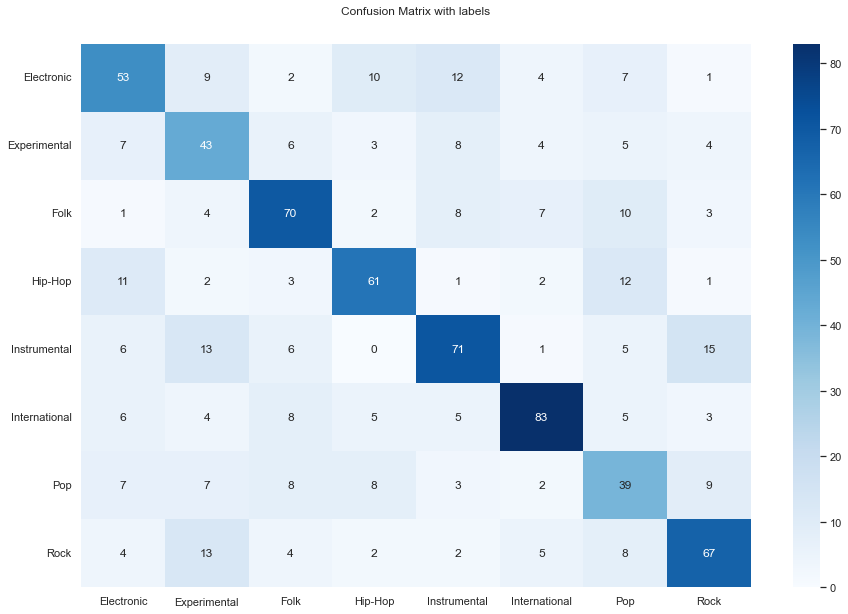

In [9]:
grid_pred = grid.predict(X_test)

print("Accuracy:", accuracy_score(y_test, grid_pred))
print("\nClassification Report:")
print(classification_report(y_test, grid_pred))
cf_mat = confusion_matrix(y_test, grid_pred)
sns.set(rc = {'figure.figsize':(15,10)})

ax = sns.heatmap(cf_mat, annot=True, cmap='Blues', fmt='g')
ax.set_xticklabels(mlp.classes_)
kwargs = {'rotation': 'horizontal'}
ax.set_yticklabels(mlp.classes_, **kwargs)

ax.set_title('Confusion Matrix with labels\n\n')

## Display the visualization of the Confusion Matrix.
plt.show()

In [195]:
import pickle

mlp_file = 'mlp_5_class_model.pkl'
pickle.dump(mlp, open(mlp_file, 'wb'))

sc = StandardScaler()
sc.fit(X_train2)
    
sc_file = 'mlp_5_class_sc.pkl'
pickle.dump(sc, open(sc_file, 'wb'))

In [309]:
import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
import pandas as pd
from scipy import stats
from pandas import DataFrame
import random

In [328]:
#filename = "../feature extraction/files/1.mp3"
#filename = "../feature extraction/files/2.mp3"
filename = "../feature extraction/files/3.mp3"
#filename = "../feature extraction/files/4.mp3"
#filename = "../feature extraction/files/5.mp3"
#filename = "../feature extraction/files/6.mp3"

print('File: {}'.format(filename))
x, sr = librosa.load(filename, sr=None, mono=True)

#print(x.shape[-1]/sr)
if (x.shape[-1]/sr > 30):
    start = random.randint(0, int(x.shape[-1]/sr)-30)
    duration = 30
else:
    start = 0
    duration = x.shape[-1]/sr
#print(start)

#x, sr = librosa.load(filename, sr=None, mono=True, offset=start, duration=duration)

print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

File: ../feature extraction/files/3.mp3


c:\Users\micha\anaconda3\envs\env1\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Duration: 240.91s, 10624000 samples


In [329]:
def columns():
    feature_sizes = dict(chroma_stft=12, chroma_cqt=12, chroma_cens=12,
                         tonnetz=6, mfcc=20, rmse=1, zcr=1,
                         spectral_centroid=1, spectral_bandwidth=1,
                         spectral_contrast=7, spectral_rolloff=1)
    moments = ('mean', 'std', 'skew', 'kurtosis', 'median', 'min', 'max')

    columns = []
    for name, size in feature_sizes.items():
        for moment in moments:
            it = ((name, moment, '{:02d}'.format(i+1)) for i in range(size))
            columns.extend(it)

    names = ('feature', 'statistics', 'number')
    columns = pd.MultiIndex.from_tuples(columns, names=names)

    return columns.sort_values()

In [330]:
features = pd.Series(index=columns(), dtype=np.float32)

def feature_stats(name, values):
        features[name, 'mean'] = np.mean(values, axis=1)
        features[name, 'std'] = np.std(values, axis=1)
        features[name, 'skew'] = stats.skew(values, axis=1)
        features[name, 'kurtosis'] = stats.kurtosis(values, axis=1)
        features[name, 'median'] = np.median(values, axis=1)
        features[name, 'min'] = np.min(values, axis=1)
        features[name, 'max'] = np.max(values, axis=1)

In [331]:
f = librosa.feature.zero_crossing_rate(x, frame_length=2048, hop_length=512)
feature_stats('zcr', f)

cqt = np.abs(librosa.cqt(x, sr=sr, hop_length=512, bins_per_octave=12,
                                 n_bins=7*12, tuning=None))
assert cqt.shape[0] == 7 * 12
assert np.ceil(len(x)/512) <= cqt.shape[1] <= np.ceil(len(x)/512)+1

f = librosa.feature.chroma_cqt(C=cqt, n_chroma=12, n_octaves=7)
feature_stats('chroma_cqt', f)
f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)
feature_stats('chroma_cens', f)
f = librosa.feature.tonnetz(chroma=f)
feature_stats('tonnetz', f)

del cqt
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
assert stft.shape[0] == 1 + 2048 // 2
assert np.ceil(len(x)/512) <= stft.shape[1] <= np.ceil(len(x)/512)+1
del x

f = librosa.feature.chroma_stft(S=stft**2, n_chroma=12)
feature_stats('chroma_stft', f)

f = librosa.feature.rms(S=stft)
feature_stats('rmse', f)

f = librosa.feature.spectral_centroid(S=stft)
feature_stats('spectral_centroid', f)
f = librosa.feature.spectral_bandwidth(S=stft)
feature_stats('spectral_bandwidth', f)
f = librosa.feature.spectral_contrast(S=stft, n_bands=6)
feature_stats('spectral_contrast', f)
f = librosa.feature.spectral_rolloff(S=stft)
feature_stats('spectral_rolloff', f)

mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
del stft
f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
feature_stats('mfcc', f)

In [332]:
features = features.to_frame().T
print(features.shape)

(1, 518)


In [333]:
sc.fit(X_train2)
features = sc.transform(features)
#print(features)
mlpprediction = mlp.predict(features)
print(mlpprediction)
bestprediction = grid.predict(features)
print(bestprediction)

['Electronic']
['Folk']
